# Model Comparison: Unet vs Resnet

In [1]:
import os
from tensorflow import keras
import tensorflow as tf

2024-01-26 14:57:07.841111: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-26 14:57:07.878554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 14:57:07.878582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 14:57:07.878613: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 14:57:07.886320: I tensorflow/core/platform/cpu_feature_g

In [2]:
def initiate_model(model_path):
    model = keras.models.load_model(filepath=model_path, compile=False)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                  metrics=["accuracy", 
                           tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=False)]
            )
    return model


In [3]:
model_path = os.path.join("..", "..", "..", "media", "FS2","models")

In [4]:
unet = initiate_model(os.path.join(model_path, "final_BT_unet_val.keras"))
resnet = initiate_model(os.path.join(model_path, "BT_resnet_unet_FT"))
resnet.summary()

2024-01-26 14:57:09.787674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13730 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d5:00.0, compute capability: 7.5


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[1][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[1][0]']          
 on)                                                                                        

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from PIL import Image
import tensorflow as tf
import os
import random
import cv2
import re
from sklearn.metrics import classification_report
import pandas as pd
from finetuning_functions import training_plots, dice_coefficient, Unet, plot_validation_masks, make_augmentations, combine_masks, numerical_sort, DataLoader
from pretraining_functions import unet_mod, Unet_encoder, BarlowTwins, resnet50_encoder
from sklearn.model_selection import KFold
from tqdm import tqdm

In [6]:
# Model parameters

input_size = (512,512)
batch_size = 16
val_batch_size = 16
random.seed(42)
epochs =15
lr = 0.00001
drop = 0.3
model_path = os.path.join("..", "..", "..", "media", "FS2","models")

In [7]:
# Load data

labeled_data_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_masks")
masked_images = [0 for i in range(150)]
smoke_masks = [0 for i in range(150)] 
cloud_masks =[0 for i in range(150)]
image_nos = []


In [8]:
# loading masks
for subdir, dirs, files in os.walk(labeled_data_dir):
    for file in files:
        file_path = os.path.join(labeled_data_dir, file)
        mask = np.load(os.path.join(labeled_data_dir, file))
        image_no = int(file.split("-")[1])-1
        image_nos.append(image_no)
        if "Smoke" in file_path and not "cloud" in file:
            smoke_masks[image_no] = mask
        if "cloud" in file:
            cloud_masks[image_no] = mask

In [9]:
# correcting masks
for i in range(len(smoke_masks)):
    if np.shape(cloud_masks[i]) == ():
        blank_img = np.zeros(smoke_masks[i].shape,dtype=np.uint8)
        cloud_masks[i] = blank_img
    if np.shape(smoke_masks[i]) == ():
        blank_img = np.zeros(cloud_masks[i].shape,dtype=np.uint8)
        smoke_masks[i] = blank_img

assert(len(smoke_masks) == len(cloud_masks))

In [10]:
# storing masks
masked_images = combine_masks(smoke_masks, cloud_masks)

In [11]:
# loading images
originals = []
original_image_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_images")
for subdir, dirs, files in os.walk(original_image_dir):
    for file in sorted(files, key=numerical_sort):
        image = Image.open(os.path.join(original_image_dir, file)).convert('RGB')
        np_original = np.asarray(image)
        originals.append(np_original)
originals = originals[:150]

assert(len(originals) == len(masked_images))

In [12]:
# preparing data
dataset = DataLoader(masked_images, originals, target_shape=input_size)
inputs, targets = dataset.data_generator(150)

In [13]:
# define validation set - prevent data leakage in model training
random.seed(42)
val_inds = random.sample([i for i in range(150)], 25)
val_inputs = [inputs[ind] for ind in val_inds]
val_targets = [targets[ind] for ind in val_inds]
inputs = [inputs[ind] for ind in range(150) if ind not in val_inds]
targets = [targets[ind] for ind in range(150) if ind not in val_inds]

random.seed(512)
sample_ind = random.sample([i for i in range(len(val_inputs))], 3)
sample_input = [val_inputs[ind] for ind in sample_ind]
sample_target = [val_targets[ind] for ind in sample_ind]
sam = tf.data.Dataset.from_tensor_slices((sample_input, sample_target))
sam_batch = sam.batch(3)

In [14]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("sequoiaandrade/Smoke-Cloud-Segmentation-RACE-ODIN")
preds = model.predict(sam_batch)
preds = tf.argmax(preds, axis=-1)


/home/sandrade/miniconda3/envs/odin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
variables/variables.index: 100%|██████████| 17.3k/17.3k [00:00<00:00, 27.5MB/s]

saved_model.pb: 100%|██████████| 1.60M/1.60M [00:00<00:00, 23.2MB/s]
Fetching 6 files:  67%|██████▋   | 4/6 [00:00<00:00,  5.52it/s]

variables.data-00000-of-00001: 100%|██████████| 26.0M/26.0M [00:00<00:00, 60.2MB/s]
Fetching 6 files: 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]
2024-01-26 14:57:30.479427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


1/1 [==============================] - 2s 2s/step


In [15]:
def convert_mask_to_colors(mask):
    mapping = {0: 0, 1: 127.5, 2: 225}
    k = np.array(list(mapping.keys()))
    v = np.array(list(mapping.values()))
    mapping_ar = np.zeros(k.max()+1,dtype=v.dtype)
    mapping_ar[k] = v
    mask = mapping_ar[mask]
    return mask

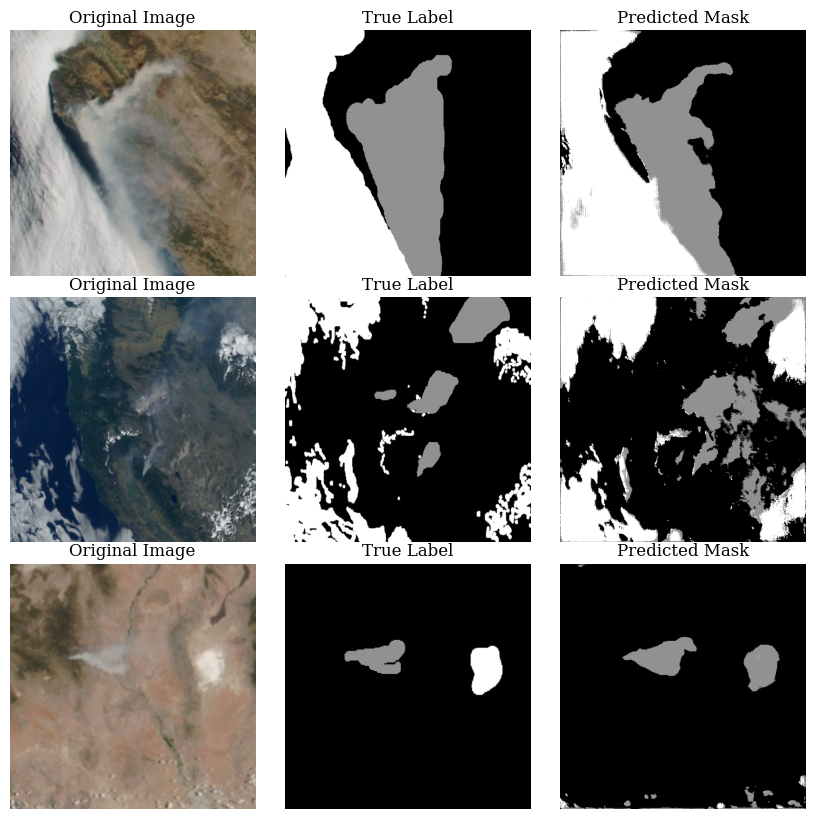

In [16]:
plt.rcParams["figure.figsize"] = (8, 8)
i=0
for ind in range(len(sample_ind)):
    plt.subplot(3, 3, 1+(3*i))
    plt.imshow(sample_input[ind])
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(3, 3, 2+(3*i))
    plt.imshow(convert_mask_to_colors(sample_target[ind]), cmap='gray')
    plt.title("True Label")
    plt.axis("off")

    plt.subplot(3, 3, 3+(3*i))
    plt.imshow(convert_mask_to_colors(preds[i]), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    i+=1

plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.1)
plt.savefig("example_outputs.pdf",bbox_inches="tight")


In [17]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fold_val = tf.data.Dataset.from_tensor_slices((val_inputs, val_targets))
val_batches = fold_val.batch(val_batch_size)
images, labels = tuple(zip(*fold_val))
preds = model.predict(val_batches)
pred_mask = tf.argmax(preds, axis=-1)


2/2 [==============================] - 5s 2s/step


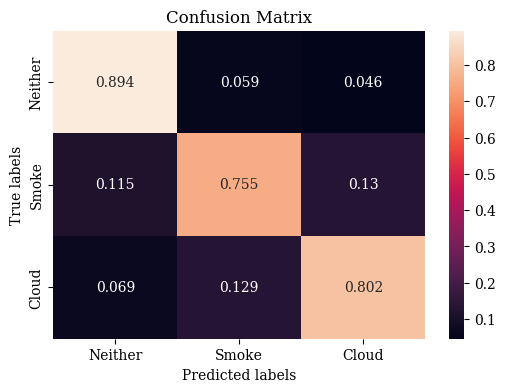

In [18]:
import seaborn as sns
lab_map = {0:"Neither", 1: "Smoke", 2: "Cloud"}
cm = confusion_matrix(np.array(labels).flatten(), np.array(pred_mask).flatten(), labels=[0,1,2], normalize="true").round(3)
#ax= plt.subplot()
fig, ax = plt.subplots(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Neither", "Smoke", "Cloud"]); ax.yaxis.set_ticklabels(["Neither", "Smoke", "Cloud"])
plt.savefig("confusion_matrix.pdf")
plt.show()

In [19]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state(labels, pred_mask)
m.result().numpy()

0.681614

In [20]:
np_pred = pred_mask.numpy()
np_labels = np.array(labels)

In [21]:
np_pred[np_pred == 2] = 0
np_labels[np_labels==2] = 0
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(np_labels, np_pred)
m.result().numpy()

0.69542575

In [22]:
labels

(<tf.Tensor: shape=(512, 512), dtype=uint8, numpy=
 array([[2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [1, 2, 2, ..., 0, 0, 0],
        [0, 2, 2, ..., 0, 0, 0]], dtype=uint8)>,
 <tf.Tensor: shape=(512, 512), dtype=uint8, numpy=
 array([[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)>,
 <tf.Tensor: shape=(512, 512), dtype=uint8, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>,
 <tf.Tensor: shape=(512, 512), dtype=uint8, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
   

# CZU image: Unet

In [23]:
test_img = "OR_ABI-L2-MCMIPC-M6_G17_s20202321716176_e20202321718555_c20202321719081.tif"